In [31]:
import os
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [32]:
# Configure TensorFlow for CPU optimization
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce TF logging
tf.config.threading.set_intra_op_parallelism_threads(4)  # Adjust based on CPU cores
tf.config.threading.set_inter_op_parallelism_threads(4)
tf.config.set_soft_device_placement(True)

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Configuration
CONFIG = {
    'dataset_path': "../data/raw/CSE-CIC-IDS2018",
    'sample_size': 100000,
    'test_size': 0.2,
    'random_state': 42,
    'min_samples': 100,
    'batch_size': 128,  # Larger batch size for CPU
    'epochs': 15,
    'model_path': 'best_model.keras'
}

In [33]:
def load_and_sample_data(dataset_path, sample_size):
    """
    Load CSV files and sample data efficiently.
    
    Args:
        dataset_path (str): Path to dataset directory
        sample_size (int): Number of samples per file
    
    Returns:
        pd.DataFrame: Combined dataframe
    """
    all_files = [
        os.path.join(dataset_path, f) 
        for f in os.listdir(dataset_path) 
        if f.endswith('.csv')
    ]
    
    if not all_files:
        raise ValueError(f"No CSV files found in {dataset_path}")
    
    processed_frames = []
    logger.info(f"Starting to process {len(all_files)} files...")
    
    for file in all_files:
        try:
            # Use chunksize for memory efficiency with large files
            df = pd.read_csv(file, low_memory=False)
            if len(df) > sample_size:
                df = df.sample(n=sample_size, random_state=CONFIG['random_state'])

            
            processed_frames.append(df)
            logger.info(f"Processed: {os.path.basename(file)} ({len(df)} rows)")
            
        except Exception as e:
            logger.error(f"Error reading {file}: {e}")
            continue
    
    if not processed_frames:
        raise ValueError("No files were successfully processed")
    
    logger.info("Concatenating dataframes...")
    combined_df = pd.concat(processed_frames, ignore_index=True)
    logger.info(f"Combined dataset shape: {combined_df.shape}")
    
    return combined_df

In [34]:
def preprocess_data(df):
    """
    Clean and prepare data for modeling.
    
    Args:
        df (pd.DataFrame): Raw dataframe
    
    Returns:
        tuple: (X, y, label_counts)
    """
    # Drop unnecessary columns
    columns_to_drop = [
        'Flow ID', 'Source IP', 'Source Port', 
        'Destination IP', 'Destination Port', 'Timestamp'
    ]
    df = df.drop(columns=columns_to_drop, errors='ignore')
    
    # Handle missing values in numeric columns
    numeric_columns = df.select_dtypes(include=['number']).columns
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())
    
    # FIXED: Encode categorical columns correctly
    categorical_cols = df.select_dtypes(include=['object']).columns
    label_encoder = LabelEncoder()
    
    for col in categorical_cols:
        if col == 'Label':
            df[col] = label_encoder.fit_transform(df[col])
        else:
            df[col] = label_encoder.fit_transform(df[col])
    
    # Check label distribution
    logger.info("Original Label Distribution:")
    label_counts = df['Label'].value_counts()
    logger.info(f"\n{label_counts}")
    
    # Separate features and labels
    X = df.drop('Label', axis=1).values
    y = df['Label'].values
    
    # Normalize features
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    return X, y, label_counts

In [35]:
def prepare_data_for_training(X, y, label_counts, min_samples=100):
    """
    Prepare data for GRU model training.
    
    Args:
        X (np.array): Feature matrix
        y (np.array): Labels
        label_counts (pd.Series): Label distribution
        min_samples (int): Minimum samples per class
    
    Returns:
        tuple: (X_train, X_test, y_train, y_test)
    """
    # Filter classes with sufficient samples
    valid_classes = label_counts[label_counts >= min_samples].index.tolist()
    mask = np.isin(y, valid_classes)
    X_filtered = X[mask]
    y_filtered = y[mask]
    
    logger.info(f"\nFiltered to {len(valid_classes)} classes")
    unique, counts = np.unique(y_filtered, return_counts=True)
    logger.info(f"Class distribution: {dict(zip(unique, counts))}")
    
    # Balance data with SMOTE
    logger.info("Applying SMOTE for class balancing...")
    smote = SMOTE(random_state=CONFIG['random_state'])
    X_resampled, y_resampled = smote.fit_resample(X_filtered, y_filtered)
    
    # Convert labels to categorical
    y_resampled_cat = to_categorical(y_resampled)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled, y_resampled_cat, 
        test_size=CONFIG['test_size'], 
        random_state=CONFIG['random_state'],
        stratify=y_resampled
    )
    
    # Reshape for GRU (samples, timesteps, features)
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    logger.info(f"Training set shape: {X_train.shape}")
    logger.info(f"Test set shape: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [36]:
def create_optimized_model(input_shape, num_classes):
    """
    Create CPU-optimized model using GRU instead of LSTM.
    GRU is faster and more efficient than LSTM on CPU.
    
    Args:
        input_shape (tuple): Shape of input data
        num_classes (int): Number of output classes
    
    Returns:
        Sequential: Compiled Keras model
    """
    model = Sequential([
        Input(shape=input_shape),
        
        # GRU is 3x faster than LSTM on CPU
        GRU(64, return_sequences=True),  # Reduced from 128
        BatchNormalization(),
        Dropout(0.3),
        
        GRU(32, return_sequences=False),  # Reduced from 64
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(32, activation='relu'),
        Dropout(0.2),
        
        Dense(num_classes, activation='softmax')
    ])
    
    # Use Adam with adjusted learning rate for faster convergence
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    logger.info("\nModel Architecture:")
    model.summary(print_fn=logger.info)
    
    return model

In [37]:
def train_model(model, X_train, X_test, y_train, y_test):
    """
    Train the model with optimized callbacks.
    
    Args:
        model: Keras model
        X_train, X_test: Training and test features
        y_train, y_test: Training and test labels
    
    Returns:
        History: Training history
    """
    # Setup callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    model_checkpoint = ModelCheckpoint(
        CONFIG['model_path'],
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    # Reduce learning rate when plateau
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
    
    logger.info("\nStarting training...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=CONFIG['epochs'],
        batch_size=CONFIG['batch_size'],  # Larger batch for CPU
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )
    
    return history

In [38]:
def evaluate_and_plot(model, X_test, y_test, history):
    """
    Evaluate model and create visualization plots.
    
    Args:
        model: Trained model
        X_test, y_test: Test data
        history: Training history
    """
    # Evaluate
    logger.info("\nEvaluating model...")
    evaluation = model.evaluate(X_test, y_test, verbose=0)
    logger.info(f"Test Loss: {evaluation[0]:.4f}")
    logger.info(f"Test Accuracy: {evaluation[1] * 100:.2f}%")
    
    # Plot results
    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Loss Over Time', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
    logger.info("Training plots saved as 'training_results.png'")
    plt.show()

In [39]:
def main():
    """Main execution function."""
    try:
        logger.info("=" * 60)
        logger.info("CPU-OPTIMIZED INTRUSION DETECTION MODEL TRAINING")
        logger.info("=" * 60)
        
        # Step 1: Load data
        combined_df = load_and_sample_data(
            CONFIG['dataset_path'],
            CONFIG['sample_size']
        )
        
        # Step 2: Preprocess
        X, y, label_counts = preprocess_data(combined_df)
        
        # Step 3: Prepare for training
        X_train, X_test, y_train, y_test = prepare_data_for_training(
            X, y, label_counts, 
            min_samples=CONFIG['min_samples']
        )
        
        # Step 4: Create model
        model = create_optimized_model(
            (X_train.shape[1], X_train.shape[2]), 
            y_train.shape[1]
        )
        
        # Step 5: Train
        history = train_model(model, X_train, X_test, y_train, y_test)
        
        # Step 6: Evaluate and visualize
        evaluate_and_plot(model, X_test, y_test, history)
        
        logger.info("\n" + "=" * 60)
        logger.info("TRAINING COMPLETED SUCCESSFULLY!")
        logger.info("=" * 60)
        
    except Exception as e:
        logger.error(f"An error occurred: {e}", exc_info=True)
        raise

2025-11-07 12:08:51,670 - INFO - ============================================================
2025-11-07 12:08:51,671 - INFO - CPU-OPTIMIZED INTRUSION DETECTION MODEL TRAINING
2025-11-07 12:08:51,671 - INFO - ============================================================
2025-11-07 12:08:51,672 - INFO - Starting to process 14 files...
2025-11-07 12:08:51,831 - INFO - Processed: DoS attacks-Slowloris.csv (36754 rows)
2025-11-07 12:08:51,840 - INFO - Processed: Brute Force -Web.csv (2073 rows)
2025-11-07 12:09:07,537 - INFO - Processed: DDoS attacks-LOIC-HTTP.csv (100000 rows)
2025-11-07 12:09:07,559 - INFO - Processed: DDOS attack-LOIC-UDP.csv (5784 rows)
2025-11-07 12:09:10,739 - INFO - Processed: DoS attacks-SlowHTTPTest.csv (100000 rows)
2025-11-07 12:09:14,657 - INFO - Processed: Infilteration.csv (100000 rows)
2025-11-07 12:09:14,662 - INFO - Processed: Brute Force -XSS.csv (734 rows)
2025-11-07 12:09:15,680 - INFO - Processed: DoS attacks-GoldenEye.csv (100000 rows)
2025-11-07 12:09

2025-11-07 12:10:14,962 - INFO - Model: "sequential"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        27,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1

Epoch 1/15
58688/58692 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8317 - loss: 0.3819
Epoch 1: val_accuracy improved from -inf to 0.86570, saving model to best_model.keras
58692/58692 ━━━━━━━━━━━━━━━━━━━━ 121s 2ms/step - accuracy: 0.8317 - loss: 0.3819 - val_accuracy: 0.8657 - val_loss: 0.2552 - learning_rate: 0.0010
Epoch 2/15
58675/58692 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8627 - loss: 0.2755
Epoch 2: val_accuracy improved from 0.86570 to 0.86911, saving model to best_model.keras
58692/58692 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - accuracy: 0.8627 - loss: 0.2755 - val_accuracy: 0.8691 - val_loss: 0.2516 - learning_rate: 0.0010
Epoch 3/15
58668/58692 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8648 - loss: 0.2677
Epoch 3: val_accuracy improved from 0.86911 to 0.87157, saving model to best_model.keras
58692/58692 ━━━━━━━━━━━━━━━━━━━━ 116s 2ms/step - accuracy: 0.8648 - loss: 0.2677 - val_accuracy: 0.8716 - val_loss: 0.2462 - learning_rate: 0.0010
Epoch 4/15
58669/58692 ━━

2025-11-07 12:39:27,382 - INFO - 
Evaluating model...
2025-11-07 12:40:08,233 - INFO - Test Loss: 0.2179
2025-11-07 12:40:08,234 - INFO - Test Accuracy: 87.68%
2025-11-07 12:40:08,667 - INFO - Training plots saved as 'training_results.png'


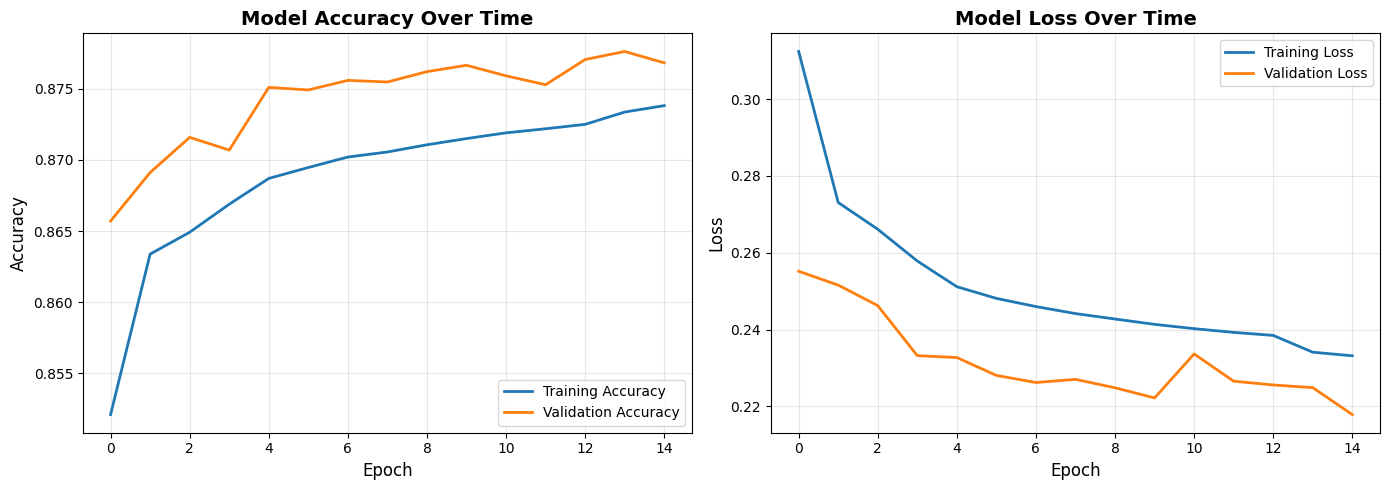

2025-11-07 12:40:08,806 - INFO - 
2025-11-07 12:40:08,815 - INFO - TRAINING COMPLETED SUCCESSFULLY!
2025-11-07 12:40:08,815 - INFO - ============================================================


In [40]:
if __name__ == "__main__":
    main()